>**Students : François MULLER et Pierre LAGUE**

# Etude Autoencodeur

Un autoencodeur est un réseau de neurones utilisé pour la réduction de dimension ; c'est-à-dire pour la sélection et l'extraction des caractéristiques. Les autoencodeurs avec plus de couches cachées que d'entrées courent le risque d'apprendre la fonction identité - où la sortie est simplement égale à l'entrée - devenant ainsi inutiles.
Les autoencodeurs de débruitage sont une extension de l'autoencodeur de base, et représentent une version stochastique de celui-ci. Les autoencodeurs de débruitage tentent de résoudre le risque de la fonction identité en corrompant aléatoirement l'entrée (c'est-à-dire en introduisant du bruit) que l'autoencodeur doit ensuite reconstruire, ou débruiter.

Une première partie de l'étude se concentre sur ces autoendcodeur de débruitage, l'optimisation de leur architecture et hyperparamètres ainsi que leur capacité à être robuste quand ils sont exposés à de nouvelles données.  Cette première partie se concentre égalmement sur l'importance de l'apprentissage de représentation et les caractéristiques de la zone latente.

In [3]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

import json
import random
from typing import Callable
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import torch.nn.functional as F

>Justification des choix des données :

Dans le but de mieux appréhender le fonctionnement des autoencodeurs et d'illustrer leur capacité générative, nous avons pris la décision de construire un ensemble de données exclusivement composé d'images représentant les chiffres 1 et 7 (MNIST Digits). Les chiffres 1 et 7 présentent des similitudes marquées dans leur écriture. En introduisant divers types de bruits (dont nous discuterons ultérieurement), il devient possible de constituer un ensemble de données très varié et d'entraîner un modèle robuste. Par souci de performance et de faisabilité logistique, nous avons restreint notre choix à deux chiffres (1 et 7). Cependant, une exploration ultérieure sera proposée, où nous inclurons tous les chiffres du dataset MNIST.

>Justification des choix des bruits :

Deux types de bruits sont déjà implémentés, à savoir le "speckle" et le "gaussian".
- Le bruit speckle, également appelé bruit de chatoiement, fait référence à toute fluctuation parasite ou toute dégradation subie par une image depuis le moment de son acquisition jusqu'à son enregistrement. Ce bruit illustre un cas concret où l'image est capturée par un appareil numérique puis transmise au modèle, la présence de bruit étant inévitable. Ce type de bruit se distingue par sa capacité à séparer le premier plan de l'arrière-plan, ce qui met en valeur le chiffre tout en le dégradant.
- Le bruit gaussien, en traitement du signal, est un bruit caractérisé par une densité de probabilité qui suit une distribution gaussienne (loi normale). Les principales sources de bruit gaussien dans les images numériques surviennent pendant l'acquisition, par exemple le bruit du capteur causé par un mauvais éclairage et/ou une température élevée. Ce bruit uniforme permet au modèle d'être plus résilient dans sa classification car il n'accentue pas le chiffre mais uniformise la dégradation de l'image.
- Le bruit "salt and pepper", ou bruit sel ou poivre, correspond à une altération aléatoire subie par une image numérique, entraînant la modification de l'intensité de certains pixels (répartis de manière aléatoire dans l'image) jusqu'à atteindre la valeur minimale ou maximale de la plage dynamique du pixel, respectivement 0 et 255 dans le cas d'une image numérique codée en 8 bits. Ce type de bruit permet au modèle de traiter des valeurs extrêmes (0 ou 255).

Chacun des bruits sera scalé avec un paramètre `scale` qui permet de modifier l'intensité de la présence du bruit dans l'image. En jouant sur les valeurs de ce paramètre nous pourront créer des données plus ou moins bruitées et donc tester les limites de robustesse de nos modèles ainsi que de leur capacité à apprendre même avec beaucoup de bruit.



In [4]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    'salt_and_pepper' Randomly chosen pixels that are converted in black or white based on a probability.
    'scale' : the scale at which the noise is present in the image. It allows to create images with little to no noise and images with a lot of noise (for model robustness).
                
We define a function that adds each noise when called from main function
Input & Output: np array
"""

def add_noise(img, noise_type="gaussian", scale=0.5):
  row, col = 28, 28
  img = img.astype(np.float32)

  match noise_type:
    case "gaussian":
      mean  = 0
      var   = 0.01
      sigma = var**.5
      noise = np.random.normal(mean, sigma, img.shape)
      noise = noise.reshape(row, col)
      img   = img + (noise*scale)
      return img
     
    case "speckle" :
      noise = np.random.randn(row, col)
      noise = noise.reshape(row, col)
      img   = img + (img*noise*scale)
      return img
     
    case "salt_pepper" :
      prob = 0.4*scale # 1/4 is the base probability of a pixel being transformed. It is scaled down or up with the scale parameter
      output = img.copy()
      if len(img.shape) == 2:
          black = 0
          white = 1
        
      probs = np.random.random(output.shape[:2])
      output[probs < (prob/2)] = black
      output[probs > 1-(prob/2)] = white
      return output     
    case _:
      return img


In [5]:
mnist_ = mnist.load_data()

# selection des chiffres 1 et 7 pour constituer nos jeux de données
train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [6]:
xtrain = np.array([minmax_scale(x) for x in xtrain])
xtest = np.array([minmax_scale(x) for x in xtest])

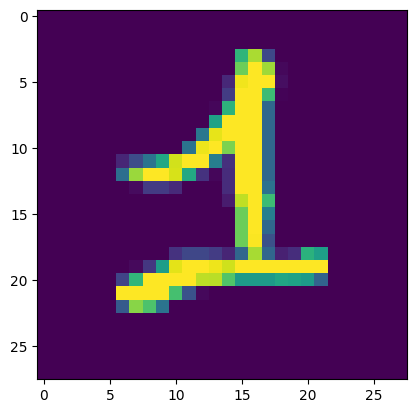

In [7]:
plt.imshow(xtrain[6].reshape((28, 28)))

In [8]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [9]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))


for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/3:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/3:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 26%|██▌       | 3340/13007 [00:00<00:00, 33140.00it/s]


gaussian noise addition completed to images


 91%|█████████ | 11859/13007 [00:00<00:00, 40873.25it/s]


speckle noise addition completed to images


100%|██████████| 13007/13007 [00:00<00:00, 39938.21it/s]



salt_pepper noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 43738.27it/s]


gaussian noise addition completed to images

speckle noise addition completed to images

salt_pepper noise addition completed to images


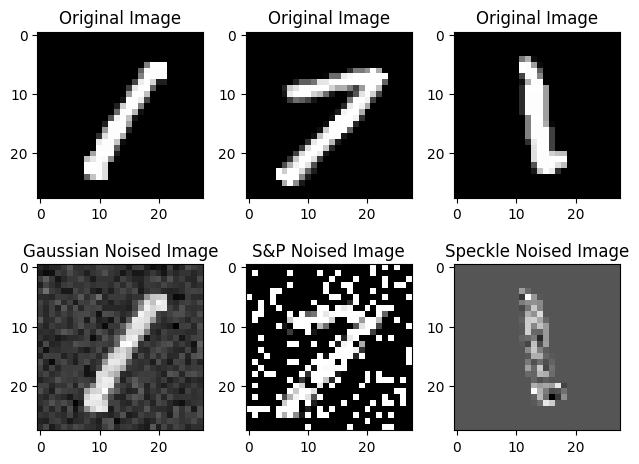

In [10]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,3)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Gaussian Noised Image")

#showing images with salt and pepper noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("S&P Noised Image")

#showing imags with the speckle noise
axes[0,2].imshow(xtrain[5000], cmap='gray')
axes[0,2].set_title("Original Image")
axes[1,2].imshow(traindata[5000], cmap="gray")
axes[1,2].set_title("Speckle Noised Image")

plt.tight_layout()

### Création d'un dataset bruité

La classe NoisedDataset, comme son nom l'indique est un dataset composé d'images bruitées. Le dataset est composé de tuples ayant la structure suivante :

$x = (image\_bruitée, image\_originale, label)$

Les types de bruits sont répartis uniformément dans le dataset de sorte à ce qu'il n'y ait pas de biais/déséquilibre.
Les fonctions de classe __len__ et __getitem__ vont nous permettre d'utiliser cette classe pour créer des dataloader rendant ainsi plus rapide le passage d'images en batch pendant l'entraînement.

In [11]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [12]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [13]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

### Definition de l'Autoencodeur de débruitage

Cet autoencodeur de débruitage est capable de prendre en entrée des images (ou des vecteurs) et de les encoder dans un espace de dimension réduite appelé "zone latente". Il les décode ensuite à partir de cet espace latent pour reconstruire l'entrée initiale sans le bruit.

Voici une explication des principaux éléments :

- La classe *denoising_model* est une sous-classe de nn.Module, ce qui signifie qu'elle hérite des fonctionnalités de base de PyTorch pour les modèles de réseaux de neurones.

- L'initialisateur __init__ de la classe permet de définir la structure de l'autoencodeur en spécifiant le nombre de couches cachées (hidden_layer_nb), le nombre de neurones dans chaque couche cachée (hidden_size), le nombre de neurones dans la zone latente (latent_size) et la taille de l'image en entrée (img_size).

- L'encodeur est une séquence de couches linéaires (fully connected) suivies de fonctions d'activation ReLU. Ces couches transforment l'entrée en une représentation de dimension réduite dans l'espace latent.

- Le décodeur est également une séquence de couches linéaires suivies de fonctions d'activation ReLU, mais cette fois-ci il restaure l'entrée originale à partir de la représentation de l'espace latent.

- La fonction forward est une méthode requise par PyTorch pour définir comment les données traversent le réseau. Dans ce cas, elle encode d'abord les données avec l'encodeur puis les décode avec le décodeur.

- La méthode get_latent_size retourne la taille de la zone latente.



In [14]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  """
  Autoencodeur, capable d'être personnalisé au niveau du nombre de neurones dans la / les couche(s) cachée(s) et au nombre de couches cachées.

  Paramètres :
  ------------
  `hidden_layer_nb`: int (default=1)  
    Nombre de couche cachées
  `hidden_size`: int (default=256)
    Nombre de neurones dans chaque couche de la couche cachée
  `latent_size`: int (default=64)  
    Nombre de neurone dans la zone latente
  """
  def __init__(self, hidden_layer_nb=1, hidden_size = 256, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()

    self.latent_size = latent_size

    encode_sequence_input = [nn.Linear(img_size, hidden_size), nn.ReLU()]
    encode_sequence_output = [nn.Linear(hidden_size, latent_size), nn.ReLU()]
    encode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      encode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      encode_sequence_hidden.append(nn.ReLU())

    encode_sequence = encode_sequence_input + encode_sequence_hidden + encode_sequence_output
        
    self.encoder = nn.Sequential(
      *encode_sequence
    )

    decode_sequence_input = [nn.Linear(latent_size, hidden_size), nn.ReLU()]
    decode_sequence_output = [nn.Linear(hidden_size, img_size), nn.Sigmoid()]
    decode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      decode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      decode_sequence_hidden.append(nn.ReLU())

    decode_sequence = decode_sequence_input + decode_sequence_hidden + decode_sequence_output

    self.decoder = nn.Sequential(
      *decode_sequence
    )

  def get_latent_size(self):
    return self.latent_size

  def encode(self, x):
    return self.encoder(x)
 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [17]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [18]:
model = denoising_model(hidden_layer_nb=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [19]:
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


### Definition de la methode d'entraînement du modèle

La méthode train_test permet de réaliser l'entraînement et l'évaluation d'un modèle (`model`) passé en paramètre.

Cette méthode permet de spécifier l'optimisateur utilisé ainsi que la loss, le nombre d'epochs, le device (pour la gpu acceleration), le trainloader et le testloader.
Il nous semblait important de pouvoir spécifier tous ces paramètres afin de rendre la méthode la plus réutillisable possible.

Pendant la phase d'entraînement, nous calculons la perte moyenne de l'epoch afin de garder une trace de la performance du modèle.


Cette fonction permet d'entraînet le modèle mais aussi de l'évaluer. En effet, après la phase d'entraînement sur le trainloader, nous calculons la loss totale (MSE) sur le testloader.
Ce calcul est fait manuellement : 

- nous comparons la valeur du label à la valeur prédite par le modèle. En fonction de la nature du testloader, il est important de modifier le type des données de test afin qu'elles soient compatibles en entrée avec le modèle (d'où les transtypages en tenseurs).
- la true_error est incrémentée de 1 si le label et la prédiction correspondent, 0 sinon

Au final nous retournons l'ensemble des loss au fil des epochs et la true_error.



In [20]:
def train_test(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.Module, 
        epochs: int,
        device: str,
        trainloader: torch.utils.data.DataLoader, 
        testset: torch.utils.data.Dataset):
    """
    Fonction pour entraîner / tester un modèle.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle à entraîner.
    optimizer : torch.optim.Optimizer
        L'optimiseur utilisé pour la mise à jour des poids du modèle.
    criterion : torch.nn.Module
        La fonction de perte utilisée pour évaluer la différence entre les prédictions et les vraies étiquettes.
    epochs : int
        Le nombre d'époques d'entraînement.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        Le DataLoader contenant les données d'entraînement.
    testset : torch.utils.data.Dataset
        Le jeu de données de test utilisé pour évaluer le modèle après chaque époque.

    Returns:
    --------
    true_error : float
        L'erreur moyenne quadratique sur le jeu de données de test.
    losslist : list
        Liste des valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.
    """
    model.train()
    losslist = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for dirty, clean, label in trainloader:  
            
            dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
            clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
            dirty, clean = dirty.to(device), clean.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model.forward(dirty)
            loss = criterion(output, clean)

            # Rétropropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calcul de la perte moyenne pour cette époque
        losslist.append(running_loss/len(trainloader))

    # Calcul de l'erreur moyenne quadratique sur le jeu de données de test
    true_error = 0
    for test in testset:
        true_error += mean_squared_error(test.flatten(), model(torch.tensor(test.flatten()).type(torch.FloatTensor)).detach())
    true_error /= len(testset)

    return true_error, losslist

Nous entraînons un modèle type autoencodeur de béruitage qui nous servira de baseline pour comparer les autres modèles.

In [21]:
# train_test(model, optimizer, criterion, 120, device, trainloader, testdata)

### Optimisation de l'architecture du modèle
Cette phase d'optimisation est importante pour trouver le meilleur modèle dans l'espoir qu'il puisse avoir une bonne capacité de généralisation.

In [22]:


def gridsearch(model_obj: nn.Module, 
               parameters: dict,
               optimizer: optim.Optimizer,
               criterion,
               learning_rate :int,
               epoch: int,
               device: str,
               trainloader: DataLoader,
               testdata: Dataset):
    """
    Effectue une recherche sur grille pour trouver les meilleurs hyperparamètres pour un modèle donné.

    Parameters:
    -----------
    model_obj : nn.Module
        Classe du modèle à utiliser pour la recherche sur grille.
    parameters : dict
        Dictionnaire contenant les hyperparamètres à tester.
    optimizer : torch.optim.Optimizer
        L'optimiseur à utiliser pour la mise à jour des poids du modèle.
    learning_rate : int
        Taux d'apprentissage à utiliser avec l'optimiseur.
    epoch : int
        Nombre d'époques d'entraînement pour chaque configuration de paramètres.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        DataLoader contenant les données d'entraînement.
    testdata : torch.utils.data.Dataset
        Jeu de données de test utilisé pour évaluer le modèle après chaque configuration de paramètres.

    Returns:
    --------
    results : dict
        Dictionnaire contenant les résultats de la recherche sur grille.
        Chaque clé correspond à l'indice de la configuration de paramètres.
        Chaque valeur est un dictionnaire contenant les paramètres testés, l'erreur réelle (sur les données de test)
        et l'erreur d'entraînement (sur les données d'entraînement) pour cette configuration.
    """
    parameters = ParameterGrid(parameters)
    results = {}
    loss = criterion()

    for i, params in enumerate(parameters):
        tmp_model = model_obj(**params)
        tmp_optim = optimizer(tmp_model.parameters(), lr=learning_rate)
        tmp_result = train_test(tmp_model, tmp_optim, loss, epoch, device, trainloader, testdata)
        print(f"\tParams {i}/{len(parameters)} -> true error: {tmp_result[0]}")
        results[i] = {
            "params": params,
            "true_error": tmp_result[0],
            "training_error": tmp_result[1]
        }

    return results

In [23]:
parameters = {"hidden_layer_nb": range(1, 6, 2),
              "hidden_size": range(300, 501, 100),
              "latent_size": [7*7, 8*8, 9*9]}



In [24]:
# results = gridsearch(denoising_model, parameters, optim.Adam, nn.MSELoss, 1e-4, 30, device, trainloader, testdata)

In [25]:
# # on enregistre les résultats pour ne pas devoir refaire la gridsearch
# with open("output_gridsearch.json", "w+") as file:
#     file.write(json.dumps(results, indent=1))

# on lit les résultats de l'ancienne gridsearch
with open("output_gridsearch.json") as file:
    results = json.loads(file.read())

In [26]:
[results[str(i)]["params"] for i in range(27) if results[str(i)]["true_error"] == min([results[str(j)]["true_error"] for j in range(27)])][0]

{'hidden_layer_nb': 1, 'hidden_size': 500, 'latent_size': 81}

Afin de trouver le meilleur modèle pour cette tâche, nous avons réalisé un grid search sur plusieurs paramètres :
- Le nombre de couches de la couche cachée (par le paramètres `hidden_layer_nb`)
- Le nombre de neurones de la couche cachées (par le paramètres `hidden_size`)
- Le nombre de neurones de la zone latente (par le paramètres `latent_size`)  

On a pris des carré de nombre pour l'espace latent, pour pouvoir les affichers plus tard dans le même format que les images d'origines (qui sont carrés). Ceci sera aussi utile lors de la classification, car nous pouvons faire un un réseau de convolution tout en respectant la forme de base de l'image.

Nous n'avons fait que 30 itérations par test dans le grid search, par faute de temps (le programme a tourné pendant plus d'une heure rien qu'avec 30 itérations). Nous utilisions le même optimiseur et pas d'apprentissage que dans notre premier test.  

Le meilleur modèle possède donc cette forme :
```
denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
```
C'est à dire, par rapport aux paramètres donnés :
- Le paramètre `hidden_layer_nb` vaut 1
- Le paramètre `hidden_size` vaut 500
- Le paramètre `latent_size` vaut 81 (donc $9 \times 9$)

In [27]:
best_model = denoising_model(**[results[str(i)]["params"] for i in range(27) if results[str(i)]["true_error"] == min([results[str(j)]["true_error"] for j in range(27)])][0])
best_model_optim = optim.Adam(best_model.parameters(), lr=1e-3)
best_model_criterion = nn.MSELoss()
print(best_model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [28]:
# true_error, losslist = train_test(best_model, best_model_optim, best_model_criterion, 100, device, trainloader, testdata)
best_model.load_state_dict(torch.load("model", map_location=device))

<All keys matched successfully>

In [29]:
# plt.plot(range(len(losslist)), losslist), true_error

On teste le modèle avec des données bruitées, mais de la même intensité que dans l'entraînement :

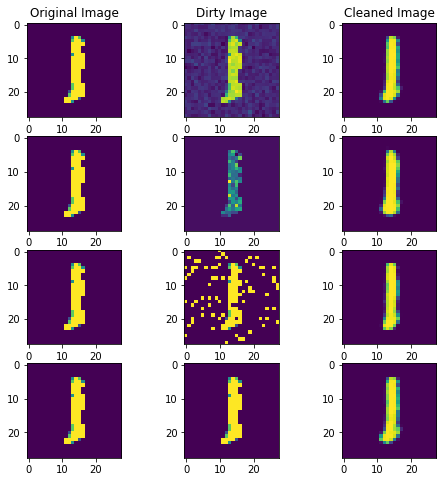

In [30]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[3]), noise)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[3])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

L'affichage de ces images montre que notre modèle `best_model` est capable de reconstituer l'image originale malgrès la présence de bruit. On remarque même que l'image reconstituée à des contours plus précis que l'image originale.

Après avois établi cette baseline, nous pouvons nous intéresser à la robustesse de nos modèles. Ceci peut se faire en augmentant le bruit (paramètre `scale`). Le modèle va maintenant avoir des images beaucoup plus bruitées que celles sur lesquelles il s'est entraîné.

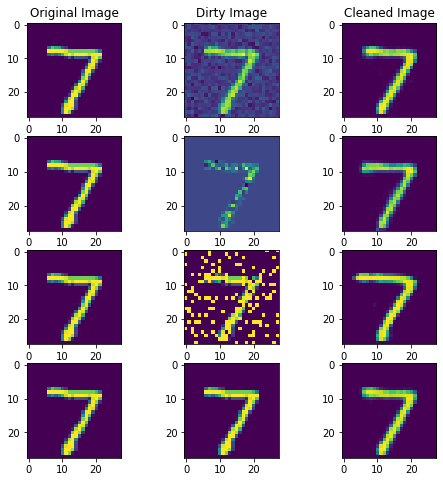

In [31]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[0]), noise, 0.8)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[0])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

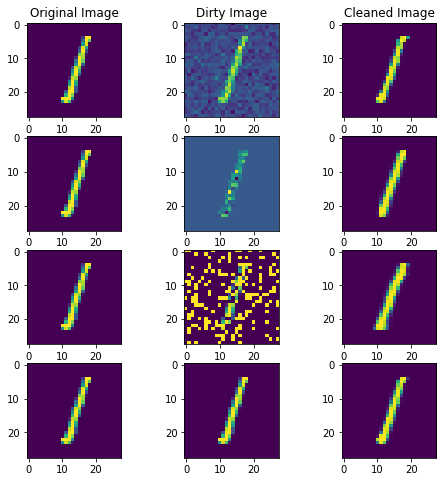

In [32]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[1]), noise, 1)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[1])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

De la même manière, ces images montrent que notre modèle est capable de reconstituer des images même si le degré de bruit est élevé. 

In [34]:
# PATH = "model"
# torch.save(best_model.state_dict(), PATH)  # We save the model state dict at PATH   

On va faire les mêmes procédures pour les données.

In [35]:
(xtrain_all, ytrain_all) = mnist_[0][0], mnist_[0][1]
(xtest_all, ytest_all) = mnist_[1][0], mnist_[1][1]

xtrain_all = np.array([minmax_scale(x) for x in xtrain_all])
xtest_all = np.array([minmax_scale(x) for x in xtest_all])

In [36]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata_all = np.zeros((len(xtrain_all), 28, 28))


for idx in tqdm(range(len(xtrain_all))):
  if noise_ct < len(xtrain_all)/3:
    noise_ct += 1
    traindata_all[idx] = add_noise(xtrain_all[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata_all = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest_all))):
  if noise_ct < len(xtest)/3:
    x = add_noise(xtest_all[idx], noise_type=noises[noise_id])
    testdata_all[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 38%|███▊      | 23085/60000 [00:01<00:02, 15246.87it/s]


gaussian noise addition completed to images


 72%|███████▏  | 43452/60000 [00:02<00:00, 16750.92it/s]


speckle noise addition completed to images


100%|██████████| 60000/60000 [00:03<00:00, 15862.69it/s]



salt_pepper noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 15634.92it/s]


gaussian noise addition completed to images


In [37]:
trainset_all = noisedDataset(traindata_all, xtrain_all, ytrain_all, tsfms)
testset_all= noisedDataset(testdata_all, xtest_all, ytest_all, tsfms)

In [38]:
trainloader_all = DataLoader(trainset_all, batch_size=500, shuffle=True)
testloader_all  = DataLoader(testset_all, batch_size=1, shuffle=True)

On reprends la même architecture de modèle trouvée avant.

In [39]:
best_model_all = denoising_model(**[results[str(j)]["params"] for j in range(27) if results[str(j)]["true_error"] == min([results[str(i)]["true_error"] for i in range(27)])][0])
best_model_criterion_all = nn.MSELoss()
best_model_optim_all = optim.Adam(best_model_all.parameters(), lr=4e-3)
best_model_all

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [40]:
testset_all = np.array([testset_all[i][0].numpy() for i in range(len(testset_all))])

In [46]:
# true_error_all, losslist_all = train_test(best_model_all, best_model_optim_all, best_model_criterion_all, 100, device, trainloader_all, testset_all)
best_model_all.load_state_dict(torch.load("model_all", map_location=device))

100%|██████████| 100/100 [08:20<00:00,  5.00s/it]


In [47]:
true_error_all

0.014460555579532694

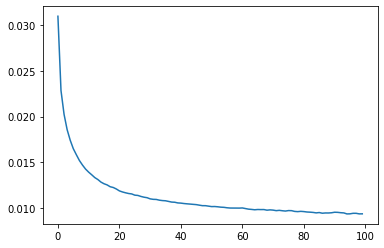

In [48]:
plt.plot(losslist_all)

On observe que la loss de notre modèle décroit au fil des epochs en se rapprochant de 0. 
Après 100 epochs, on peut voir qu'on peut potentiellement atteindre une loss plus basse en augmentant le nombre d'épochs. Cependant, c'est un modèle très lourd (toutes les classes sont comprises) et l'entraînement peut prendre plusieurs 10aines de minutes.

In [49]:
torch.save(best_model_all.state_dict(), "model_all")  # We save the model state dict at PATH   

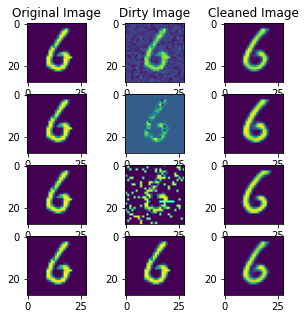

In [50]:
f,axes= plt.subplots(4,3,figsize=(5,5))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    clean = xtest_all[50]
    dirty = add_noise(np.array(clean), noise, 0.8)
    predicted = best_model_all(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(clean)
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

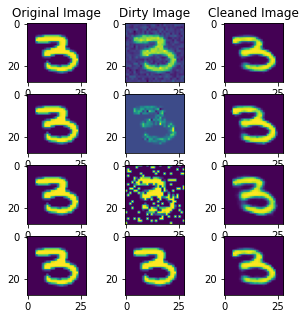

In [51]:
f,axes= plt.subplots(4,3,figsize=(5,5))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    clean = xtest_all[51]
    dirty = add_noise(np.array(clean), noise, 0.8)
    predicted = best_model_all(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(clean)
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

Nous observons que le modèle possédant toutes les classes est capable de reconstituer les images malgré un bruit important. 
Le précédent modèle n'ayant pas eu d'images autre que 1 et 7 n'était pas capable de reconstituer des images d'autres chiffres. Ici, on observe bien le principe d'apprentissage de représentation via la zone latente, où multiples classes sont apprises par l'encodeur et ainsi reconstituées par le décodeur.

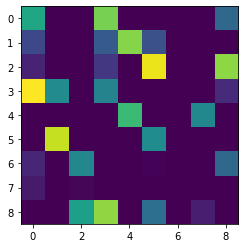

In [52]:
plt.imshow(best_model_all.encode(torch.tensor(dirty.flatten()).type(torch.FloatTensor)).detach().numpy().reshape((9, 9)))

Il est possible d'extraire la zone latente entre l'encodeur et le decodeur. Cette zone latente est la version la plus réduite de l'image (9x9 pixels contre 28x28 à l'origine). C'est ce type de données qui va permettre au modèle de réaliser l'apprentissage de représentation. Ce type de données sera utilisé plus tard dans l'étude pour faire un Encodeur-CNN : 

- un classifieur ayant comme architecture encodeur -> zone latente -> input pour CNN -> multi-classification.

# <span style="color:red">LA SUITE LE CODE N'EST PAS FINIT

In [279]:
def train_test_classifier(
        model: torch.nn.Module, 
        autoencoder: torch.nn.Module,
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.Module, 
        epochs: int,
        device: str,
        trainloader: torch.utils.data.DataLoader, 
        labels: torch.utils.data.Dataset,
        batch_size: int):
    """
    Fonction pour entraîner / tester un modèle.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle à entraîner.
    optimizer : torch.optim.Optimizer
        L'optimiseur utilisé pour la mise à jour des poids du modèle.
    criterion : torch.nn.Module
        La fonction de perte utilisée pour évaluer la différence entre les prédictions et les vraies étiquettes.
    epochs : int
        Le nombre d'époques d'entraînement.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        Le DataLoader contenant les données d'entraînement.
    testset : torch.utils.data.Dataset
        Le jeu de données de test utilisé pour évaluer le modèle après chaque époque.

    Returns:
    --------
    true_error : float
        L'erreur moyenne quadratique sur le jeu de données de test.
    losslist : list
        Liste des valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.
    """
    model.train()
    losslist = []
    encoder_output = []
    for img in tqdm(trainloader):
        encoder_output.append(autoencoder.encode(torch.tensor(img.flatten()).type(torch.float32)).view(-1, 9, 9).clone().detach())
    training_data = DataLoader(list(zip(encoder_output, labels)), batch_size=batch_size)
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for output, label in training_data:  
            optimizer.zero_grad()

            # Forward pass
            output = model(output)
            loss = criterion(output, label.clone().detach())

            # Rétropropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calcul de la perte moyenne pour cette époque
        losslist.append(running_loss/len(trainloader))

    # Calcul de l'erreur moyenne quadratique sur le jeu de données de test

    return losslist

In [288]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1)
        self.fc = nn.Linear(1 * 1 * 1, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 1 * 1 * 1)
        x = self.fc(x)
        return x

In [289]:
classifier = CNN()
classif_optim = optim.Adam(classifier.parameters(), 1e-3)
classif_crite = nn.CrossEntropyLoss()

In [290]:
losslist_classif = train_test_classifier(classifier, best_model_all, classif_optim, classif_crite, 10, device, traindata_all, ytrain_all, 32)

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


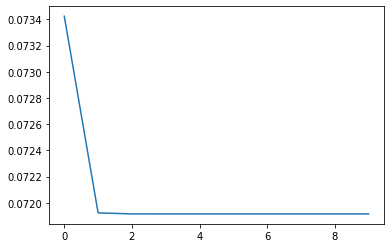

In [291]:
plt.plot(losslist_classif)

In [292]:
encode_xtest_all = []
for img in tqdm(xtest_all):
    encode_xtest_all.append(best_model_all.encode(torch.tensor(img.flatten()).type(torch.float32)).view(-1, 9, 9).clone().detach())

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 6680.35it/s]


In [293]:
encode_xtest_all[i].shape

torch.Size([1, 9, 9])

In [294]:
true_error = 0
for i in range(len(encode_xtest_all)):
    true_error += 1 if ytest_all[i] == torch.argmax(classifier(encode_xtest_all[i].type(torch.float32))) else 0
true_error /= len(encode_xtest_all)

In [295]:
true_error

0.1135

## Discussion sur les performances de modèles Encodeur-CNN et Encodeur-MLP

Après avoir testé notre Autoencodeur de débruitage, nous avons développé des architectures dérivées qui utilisent l'apprentissage de représentation de notre encodeur (nottament la zone latente) afin d'évaluer comment cette zone latente pouvait être utilisée à des fins de classification multiclasse.

La première architecture que nous avons considéré est la suivante :

```
 ____________________________________________________________________________________________
|                   Classification Encoder-CNN model (simplified version)                    |
|____________________________________________________________________________________________|
|                                                                                            |
|                   Encoder (Input: img_size)                                                |
|   Input --> Hidden Layers (ReLU) ... --> Output (latent zone)                              |
|                                                                                            |
|                   CNN (Input: latent_size)                                                 |
|   Input (latent zone) --> Conv2D Hidden Layers (MaxPooling2D) ... --> Output (Softmax)     |
|                                                                                            |
|____________________________________________________________________________________________|
```

Le but est que le decodeur CNN puisse utiliser la zone latente pour extraire des informations de cette dernière et effectuer une classification.
Les résultats montrent que cette architecture ne permet pas de bien classifier les chiffres dans leur représentation de zone latente. Nous pouvons penser que c'est à cause du manque d'information contextuelle de l'image qui ne permet pas au CNN d'extraire des informations nécessaire à la reconnaissance du chiffre. En observant l'image de la zone latente on voit bien que l'image manque de patterns et d'informations. En effet, les CNN sont conçus pour apprendre des représentations hiérarchiques des caractéristiques spatiales, en commençant par des bords et des textures simples jusqu'à des formes complexes et des parties d'objets. Si les données ne présentent pas cette structure hiérarchique, les couches supplémentaires dans les CNN pourraient ne pas apporter d'avantages significatifs. Une architecture trop complexe comme les CNN serait alors inutile pour ce genre de classification.


La seconde architecture que nous avons considéré est la suivante :

```
 ____________________________________________________________________________________________
|                   Classification Encoder-MLP model (simplified version)                    |
|____________________________________________________________________________________________|
|                                                                                            |
|                   Encoder (Input: img_size)                                                |
|   Input --> Hidden Layers (ReLU) ... --> Output (latent zone)                              |
|                                                                                            |
|                   MLP (Input: latent_size)                                                 |
|   Input (latent zone) --> Linear Layers (ReLU) ... --> Output (Softmax)                    |
|                                                                                            |
|____________________________________________________________________________________________|
```

De même que pour l'architecture précédente le but est que le decodeur MLP puisse utiliser la zone latente pour extraire des informations de cette dernière et effectuer une classification. Contrairement à l'étude précédente, les résultats sont très bons. Les MLP sont des réseaux entièrement connectés et peuvent apprendre des relations non linéaires complexes entre les caractéristiques d'entrée. Ils ne sont pas contraints par les relations spatiales dans les données, contrairement aux CNN qui supposent des corrélations spatiales locales dans l'entrée. Dans un espace de petite dimension comme la zone latente, les caractéristiques pertinentes pour la classification ne sont pas facilement discernables au niveau des pixels mais émergent plutôt d'une combinaison de valeurs de pixels, les MLP, grace à leur couches cachées peuvent avoir une meilleure compréhension de l'information, sans avoir a chercher des informations contextuelles. Dans ce cas, l'architecture simpliste des MLP correspond à la nature très simple des données de la zone latente.


